# Approfondissement sur les distributions 1D



## Résumé

Dans ce notebook, nous présentons les aspects suivants :
- les lois associées à plusieurs paramétrages,
- arithmétique et fonctions de distributions,
- utiliser la classe `CompositeDistribution` pour les fonctions plus générales,
- créer sa propre distribution avec la classe `PythonDistribution`,
- tronquer une distribution avec `TruncatedDistribution`.

TODO:
- exercice sur la méthode computeMinimumVolumeLevelSet

In [1]:
import openturns as ot
import numpy as np

## Lois avec plusieurs paramétrages

As mentionned in the introduction, `OpenTURNS` provides several univariate distributions, such as :
 - `Beta`, 
 - `Uniform`
 - `Normal`, 
 - `LogNormal`
 - `Exponential`, 
 - `Weibull`
 - ..
 
Univariate distributions require native parameters. For some few distributions, alternative parameters might be used for defining the distributions. 

Par exemple, la loi beta possède plusieurs paramétrages. 
Le paramétrage natif de la loi beta utilise les paramètres suivants :
- $r$ : le premier paramètre de forme, $r>0$,
- $t$ : le second paramètre de forme, $t>r$,
- $a$ : la borne inférieure,
- $b$ : la borne supérieure avec $a<b$.
La densité de probabilité de la loi beta est :
$$
f(x) = \frac{(x-a)^{r-1}(b-x)^{t-r-1}}{(b-a)^{t-1} B(r,t-r)}
$$
pour tout $x\in[a,b]$, où $B$ est la fonction beta d'Euler. 
Pour tout $y,z>0$, la fonction beta est définie par :
$$
B(y,z) = \int_0^1 t^{y-1} (1-t)^{z-1} dt.
$$
La classe `Beta` utilise le paramétrage natif.

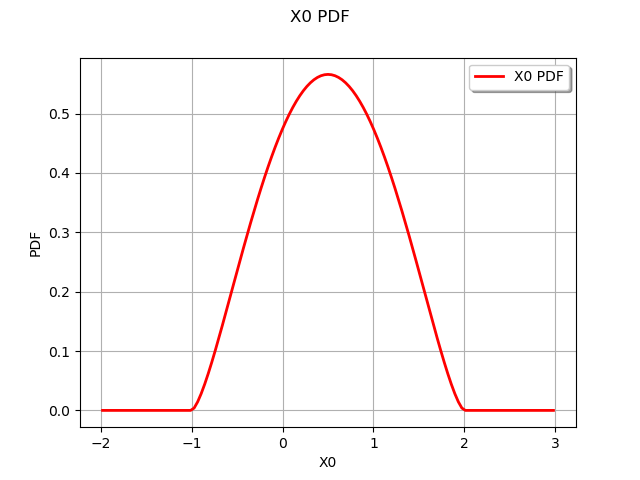

In [2]:
dist = ot.Beta(2.5, 5, -1, 2)
dist.drawPDF()

La classe `BetaMuSigma` fournit un autre paramétrage de la loi beta, fondé sur l'espérance $\mu$ et l'écart-type $\sigma$ de la variable.

En effet, la moyenne et la variance de la loi beta sont :
$$
\mu = a + \frac{(b-a)r}{t}
$$
et
$$
\sigma^2 = \left(\frac{b-a}{t}\right)^2 \frac{r(t-r)}{t+1}.
$$
En inversant les relations, on obtient :
$$
t = \frac{(b-\mu)(\mu-a)}{\sigma^2} - 1
$$
et
$$
r = \frac{\mu-a}{b-a} t.
$$
La session suivante créée une loi beta de paramètres $\mu=0.2$, $\sigma=0.6$, $a=-1$ et $b=2$.

In [3]:
parameters = ot.BetaMuSigma(0.2, 0.6, -1, 2)
parameters.evaluate()

class=Point name=Unnamed dimension=4 values=[2,5,-1,2]

La classe `ParametrizedDistribution` permet de créer une distribution en fonction d'un paramétrage.

In [4]:
param_dist = ot.ParametrizedDistribution(parameters)
param_dist

class=ParametrizedDistribution parameters=class=BetaMuSigma name=Unnamed mu=0.2 sigma=0.6 a=-1 b=2 distribution=class=Beta name=Beta dimension=1 r=2 t=5 a=-1 b=2

## Arithmétique des distributions et fonctions de distributions 1D

`OpenTURNS` provides also algebra of distributions (for univariate):
 - +, -
 - *, /

It provides also some usual operators to get the full distributions of `f(x)` with `f` equals to :
 - `sin`, 
 - `cos`, 
 - `acos`, 
 - `asin`
 - `square`, 
 - `inverse`, 
 - `sqrt`.

Dans l'exemple suivant, on crée une variable beta et une variable exponentielle, puis on crée la variable associée à la somme de ces deux variables aléatoires.

In [5]:
B = ot.Beta(5, 7, 9, 10)

In [6]:
E = ot.Exponential(3)

In [7]:
S = B + E
S.setDescription(["Sum"])

Le script suivant permet de dessiner la PDF et la CDF de la variable associée à la somme.

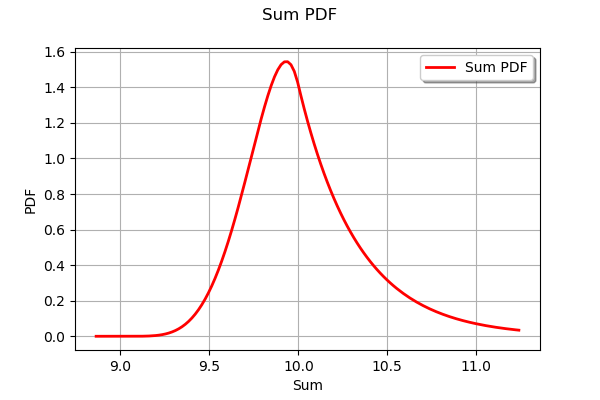

In [8]:
S.drawPDF()

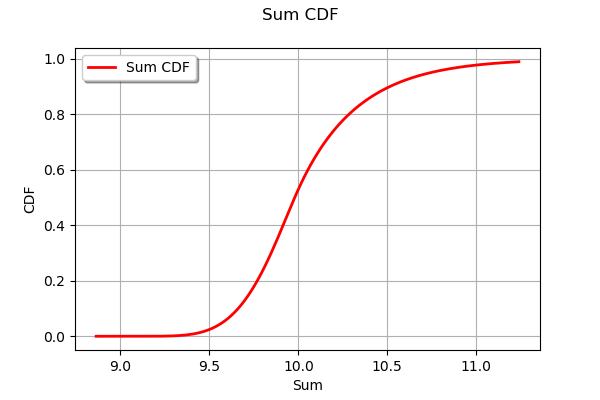

In [9]:
S.drawCDF()

## La classe `CompositeDistribution`  pour les fonctions plus générales

More complex functions can be created thanks to the `CompositeDistribution` class (requires a `f` function).

In [10]:
N = ot.Normal(0.0, 1.0)
N.setDescription(["Normal"])
# Define CompositeDistribution
f = ot.SymbolicFunction(['x'], ['exp(x)'])
f.setDescription(["X","Exp(X)"])
# Composite distribution : exp(X) ~ LN(0, 1)
dist = ot.CompositeDistribution(f, N)
dist.setDescription(["Exp(Normal())"])

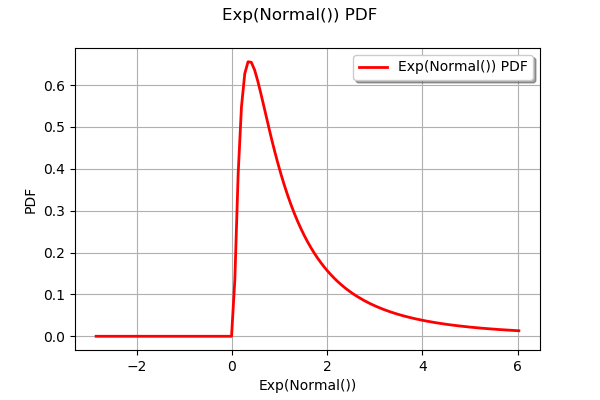

In [11]:
dist.drawPDF()

In order to check the previous distribution, we compare it to the LogNormal distribution.

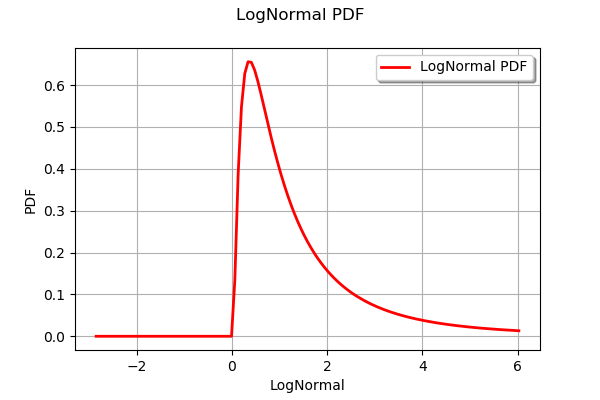

In [12]:
LN = ot.LogNormal()
LN.setDescription(["LogNormal"])
LN.drawPDF()

## La classe `PythonDistribution`

Another possibility is to define is own `distribution`. Requirements are the cumulative distribution function.

For example let us implement the `Quartic` kernel, which is sometimes used in the context of kernel smoothing. 
The PDF is defined by:
$$
f(u) = \frac{15}{16} (1 - u^2)^2
$$
for any $u\in[-1,1]$ and $f(u)=0$ otherwise. 
Expanding the previous square, we find:
$$
f(u) = \frac{15}{16} (1 - 2 u^2 + u^4)
$$
for any $u\in[-1,1]$. 
Integrating the previous equation leads to the CDF:
$$
F(u) = \frac{1}{2} + \frac{15}{16} u - \frac{5}{8} u^3 + \frac{3}{16} u^5
$$
for any $u\in[-1,1]$ and $F(u)=0$ otherwise. 

The only required method is `computeCDF`. Since the PDF is easy to define, we implement it as well. Here, the distribution is defined on the interval $[-1,1]$, so that we define the `getRange` method.

Reference
- https://en.wikipedia.org/wiki/Kernel_%28statistics%29

In [13]:
class Quartic(ot.PythonDistribution):
    def __init__(self):
        super(Quartic, self).__init__(1)
        self.c = 15.0 / 16
    
    def computeCDF(self, x):
        u = x[0]
        if u <= -1:
            p = 0.0
        elif u >= 1:
            p = 1.0
        else:
            p = 0.5 + 15./16 * u - 5. / 8 * pow(u,3) + 3./16 * pow(u,5)
        return p

    def computePDF(self, x):
        u = x[0]
        if u < -1 or u > 1:
            y = 0.0
        else:
            y = self.c * (1 - u **2)**2
        return y

    def getRange(self):
        return ot.Interval(-1, 1)

In [14]:
Q = ot.Distribution(Quartic())
Q.setDescription(["Quartic Kernel"])

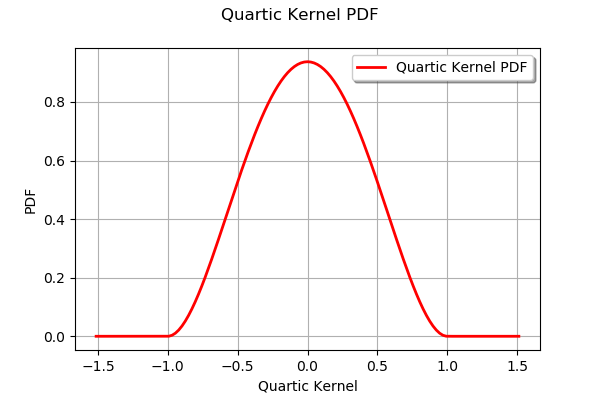

In [15]:
Q.drawPDF()

## Tronquer une distribution

Toute distribution peut être tronquée grâce à la classe `TruncatedDistribution`. 

Soit $f_X$ (resp. $F_X$) la densité de probabilité (resp. la fonction de répartition) de la variable aléatoire réelle $X$. Soient $a$ et $b$ deux réels avec $a<b$. Soit $Y$ la variable aléatoire associée à la troncature de $X$ dans l'intervalle $[a,b]$. Alors, la densité de probabilité de $Y$ est :
$$
f_Y(y) = \frac{f_X(y)}{F_X(b) - F_X(a)}
$$
si $y\in[a,b]$ et $f_Y(y)=0$ sinon. 


Considérons par exemple la variable gaussienne $X$ de moyenne $\mu=0$ et d'écart-type $\sigma=1$. 

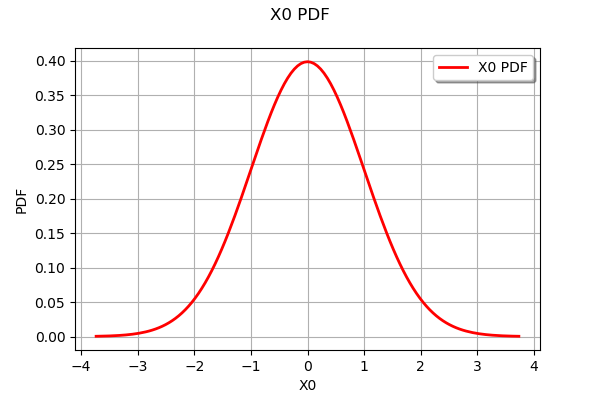

In [16]:
X = ot.Normal()
X.drawPDF()

On peut tronquer la distribution entre -1 et 2. On observe que la densité de probabilité tronquée devient discontinue aux points de troncature -1 et 2.

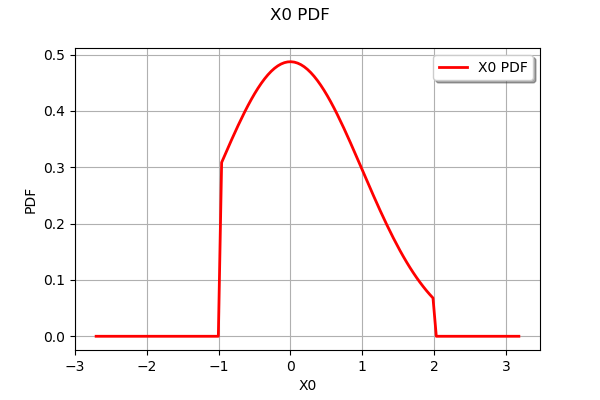

In [17]:
Y = ot.TruncatedDistribution(X,-1.,2.)
Y.drawPDF()

On peut également tronquer une distribution avec une borne inférieure.

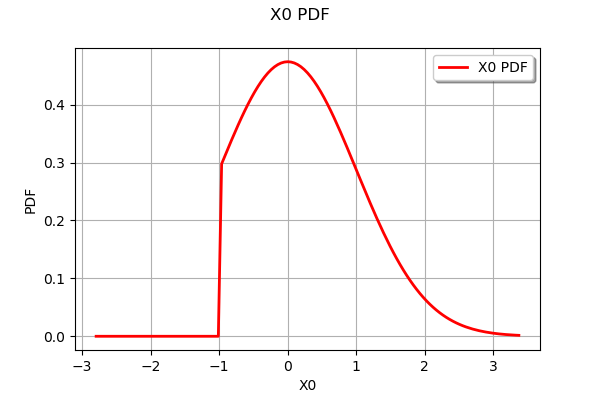

In [18]:
Y = ot.TruncatedDistribution(X,-1.,ot.TruncatedDistribution.LOWER)
Y.drawPDF()

On peut enfin tronquer une distribution avec une borne suférieure.

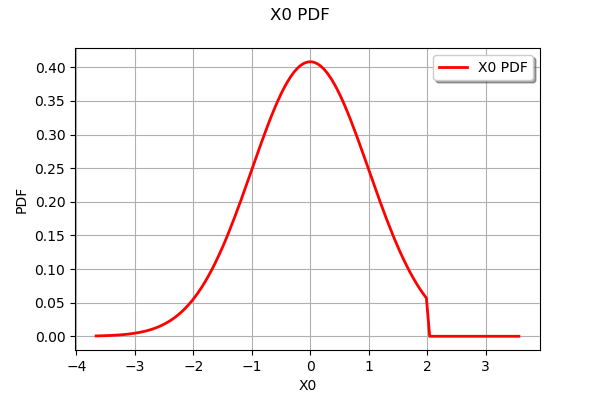

In [19]:
Y = ot.TruncatedDistribution(X,2.,ot.TruncatedDistribution.UPPER)
Y.drawPDF()

## Exercise 1 : product

We want to compute the distribution of the product of a uniform distribution and a gaussian distribution.
- Define the variable `U` with Uniform distribution with bounds a = 0, b = 1.
- Define the variable `N` with Normal distribution with parameters 0 and 1.
- Define the variable `Z = U * N` using the arithmetic operator `*`.
- Plot the PDF of `Z`.

## Exercice 2 : axial stressed beam

We consider a simple beam stressed by a traction load F at both sides.

<img src="axial-stressed-beam.png" width="250">

The geometry is supposed to be deterministic. The diameter D is:
$$
D=0.02 \textrm{ (m)}.
$$

By definition, the yield stress is the load divided by the surface. Since the surface is $\pi D^2/4$, the stress is:
$$
S = \frac{F}{\pi D^2/4}.
$$
It is considered that failure occurs when the beam plastifies, i.e. when the axial stress gets bigger than the yield stress:
$$
R - \frac{F}{\pi D^2/4} \leq 0
$$
where $R$ is the strength.
 
Therefore, the limit state function $G$ is: 
$$
G(R,F) = R - \frac{F}{\pi D^2/4},
$$
for any $R,F\in\mathbb{R}$.
The values of the parameter $D$ implies:
$$
D^2/4 = 10^{-4},
$$
which leads to the equation:
$$
G(R,F) = R - \frac{F}{10^{-4} \pi}.
$$

We consider the following distribution functions.

| Variable | Distribution |
|--|--|
| R | LogNormal($\mu_R=3\times 10^6$, $\sigma_R=3\times 10^5$) [Pa] |
| F | Normal($\mu_F=750$, $\sigma_F=50$) [N] |

where $\mu_R=E(R)$ and $\sigma_R=\sqrt{V(R)}$ are the mean and the standard deviation of $R$.

The failure probability is: 
$$
P_f = \text{Prob}(G(R,F) \leq 0).
$$

The exact $P_f$ is 
$$
P_f = 0.02920.
$$

The goal of the exercise is to compute $P_f$. 

- Define the random variable `F` associated with $F$. Draw its PDF.
- Define the random variable `R` associated with $R$. To do this, use the `LogNormalMuSigma` class. Draw its PDF.
- Define the deterministic variable `D` associated with the beam diameter.
- Define the random variable `G` associated with the equation $G = R - \frac{F}{\pi D^2/4}$, using the arithmetic operator `-`.
- Compute the probability $P_f = \text{Prob}(G \leq 0)$.

## Exercice 3 : une autre distribution uniforme

L'objectif de cet exercice est d'utiliser la classe `PythonDistribution` pour créer la nouvelle distribution `UDistribution` implémentant la loi uniforme.

La fonction de répartition de la loi uniforme est:
$$
P(X\leq x) = 
\left\{
\begin{array}{l}
0 \textrm{ si } x\leq a, \\
\frac{x-a}{b-a} \textrm{ si } x\leq b, \\
1 \textrm{ sinon}.
\end{array}
\right.
$$

- Créer la classe `UDistribution` dérivant de la classe `PythonDistribution`.
- Créer le constructeur de la classe, c'est à dire la méthode `__init__`.
- Créer la méthode `computeCDF` qui calcule la fonction de répartition.

Pour vous aider, nous vous fournissons un squelette de solution, dans lequel vous compléterez les sections de code `TODO`.
`
class UDistribution(ot.PythonDistribution):
    def __init__(self, a, b):
        super(UDistribution, self).__init__(TODO)
        TODO
    def computeCDF(self, x):
        u = x[0]
        if TODO:
            p = TODO
        elif TODO:
            p = TODO
        else:
            p = TODO
        return p
`

## Exercice 4 : un débit positif

On considère la variable Q associée au débit d'une rivière ($m^3/s$). On fait l'hypothèse qu'il s'agit du débit maximal annuel. C'est pourquoi nous choisissons de modéliser cette variable par la loi de Gumbel de paramètres suivants :
- échelle=500, 
- mode=900.

De plus, le débit est une variable positive de telle sorte que la distribution doit être tronquée avec une borne inférieure.

L'objectif de cet exercice est de définir la variable aléatoire `Q` associée à cette distribution.

- Utiliser la classe `GumbelAB` pour définir les paramètres de la loi de Gumbel associée. 
- Utiliser la classe `ParametrizedDistribution` pour créer la variable `Quntruncated` associée à la variable non tronquée.
- Dessiner la PDF de `Quntruncated`.
- Utiliser la classe `TruncatedDistribution` pour créer la variable `Q` associée à la loi de Gumbel tronquée. 
- Dessiner la PDF de `Q` : que remarquez-vous ?